In [35]:
# Importing Libraries

import pickle
import numpy as np
from keras.utils import np_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
def unpickle(file):
    with open(file,'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [17]:
def load_data(file):
    
    data = unpickle(file)
    
    #with open(file,'rb') as f:
    #    data = pickle.load(f,encoding='bytes')
    
    images_array = data[b'data']
    raw = np.array(images_array, dtype=float)/255.0
    
    images = raw.reshape([-1, 3, 32, 32])
    images = images.transpose([0,2,3,1])
    labels = np.array(data[b'labels'])
    
    return images, labels

In [18]:
def plot_images(images, labels, class_names):
    
    fig, axes = plt.subplots(3,4,figsize = (8,8))
        
    fig.subplots_adjust(hspace=0.2, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        if i <len(images):
            ax.imshow(images[i], interpolation='spline16')

            labels_true_name = class_names[labels[i]]
            
            xlabel = labels_true_name
            
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
            
    

In [19]:
# getting names of classes

raw = unpickle('batches.meta')[b'label_names']
class_names = [x.decode('utf-8') for x in raw]
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [20]:

# for training data

images_train = np.zeros(shape=[50000, 32, 32, 3], dtype = float)
labels_train = np.zeros(shape=[50000], dtype = int)
    
start = 0
    
for i in range(5):
        
    images_batch, labels_batch = load_data(file = "data_batch_"+str(i+1))
    end = start + 10000
        
    images_train[start:end,:] = images_batch
    labels_train[start:end] = labels_batch
    start = end
class_train = np_utils.to_categorical(labels_train, 10)

In [21]:
# Training Labels
print(labels_train)

[6 9 9 ... 9 1 1]


In [22]:

# for testing data

images_test, labels_test = load_data(file = "test_batch")
class_test = np_utils.to_categorical(labels_test, 10)

In [23]:
# Number of Testing data
print(len(images_test))

10000


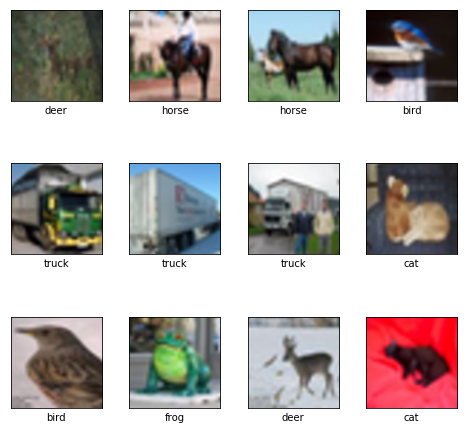

In [24]:
# Ploting training images
images = images_train[10:22]
labels = labels_train[10:22]
plot_images(images=images, labels= labels, class_names=class_names)

In [26]:
# image augmentation

datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=45,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(images_train)


In [27]:
# pure CNN model

model = Sequential()

model.add(Conv2D(96, (3,3), activation = 'relu', padding= "same", input_shape=(32, 32, 3)))

model.add(Dropout(0.2))

model.add(Conv2D(96, (3,3), activation = 'relu'))
model.add(Conv2D(96, (3,3), activation = 'relu', strides = 2))

model.add(Dropout(0.5))

model.add(Conv2D(192, (3,3), activation = 'relu'))
model.add(Conv2D(192, (3,3), activation = 'relu'))
model.add(Conv2D(192, (3,3), activation = 'relu', strides = 2))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))



model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 192)       3

In [28]:
# Checkpoint
checkpoint = ModelCheckpoint('model_cifar10.h5', 
                             monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='auto')


In [29]:
# Compile
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=1.0e-4), metrics=['accuracy'])

In [30]:
# Training Model
model_details = model.fit_generator(datagen.flow(images_train, class_train, batch_size=32),
                                   steps_per_epoch=len(images_train)/32,
                                   epochs=300, validation_data=(images_test, class_test),
                                   callbacks=[checkpoint],
                                   verbose=1)

Epoch 1/300
1563/1562 [==============================] - 60s 39ms/step - loss: 1.9976 - accuracy: 0.2449 - val_loss: 1.6043 - val_accuracy: 0.4031
Epoch 2/300
1563/1562 [==============================] - 57s 37ms/step - loss: 1.7532 - accuracy: 0.3470 - val_loss: 1.6155 - val_accuracy: 0.4076
Epoch 3/300
1563/1562 [==============================] - 61s 39ms/step - loss: 1.6362 - accuracy: 0.3949 - val_loss: 1.3857 - val_accuracy: 0.4907
Epoch 4/300
1563/1562 [==============================] - 63s 40ms/step - loss: 1.5449 - accuracy: 0.4332 - val_loss: 1.4072 - val_accuracy: 0.5016
Epoch 5/300
1563/1562 [==============================] - 63s 41ms/step - loss: 1.4781 - accuracy: 0.4652 - val_loss: 1.2291 - val_accuracy: 0.5595
Epoch 6/300
1563/1562 [==============================] - 64s 41ms/step - loss: 1.4197 - accuracy: 0.4864 - val_loss: 1.1920 - val_accuracy: 0.5659
Epoch 7/300
1563/1562 [==============================] - 65s 42ms/step - loss: 1.3702 - accuracy: 0.5046 - val_loss: 1

1563/1562 [==============================] - 65s 42ms/step - loss: 0.5610 - accuracy: 0.8063 - val_loss: 0.5025 - val_accuracy: 0.8310
Epoch 112/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5622 - accuracy: 0.8050 - val_loss: 0.4678 - val_accuracy: 0.8417
Epoch 113/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5543 - accuracy: 0.8086 - val_loss: 0.4788 - val_accuracy: 0.8397
Epoch 114/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5564 - accuracy: 0.8090 - val_loss: 0.4888 - val_accuracy: 0.8375
Epoch 115/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5536 - accuracy: 0.8096 - val_loss: 0.4683 - val_accuracy: 0.8420
Epoch 116/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5472 - accuracy: 0.8113 - val_loss: 0.4659 - val_accuracy: 0.8454
Epoch 117/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.5514 - accuracy: 0.8116 - val_loss: 0

1563/1562 [==============================] - 65s 41ms/step - loss: 0.5008 - accuracy: 0.8287 - val_loss: 0.4360 - val_accuracy: 0.8535
Epoch 167/300
1563/1562 [==============================] - 64s 41ms/step - loss: 0.4891 - accuracy: 0.8327 - val_loss: 0.4522 - val_accuracy: 0.8517
Epoch 168/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4963 - accuracy: 0.8289 - val_loss: 0.4341 - val_accuracy: 0.8533
Epoch 169/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4905 - accuracy: 0.8302 - val_loss: 0.4653 - val_accuracy: 0.8456
Epoch 170/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4887 - accuracy: 0.8320 - val_loss: 0.4466 - val_accuracy: 0.8523
Epoch 171/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4888 - accuracy: 0.8318 - val_loss: 0.4588 - val_accuracy: 0.8467
Epoch 172/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4912 - accuracy: 0.8327 - val_loss: 0

1563/1562 [==============================] - 63s 41ms/step - loss: 0.4622 - accuracy: 0.8412 - val_loss: 0.4260 - val_accuracy: 0.8576
Epoch 222/300
1563/1562 [==============================] - 63s 41ms/step - loss: 0.4551 - accuracy: 0.8428 - val_loss: 0.4502 - val_accuracy: 0.8491
Epoch 223/300
1563/1562 [==============================] - 65s 41ms/step - loss: 0.4564 - accuracy: 0.8426 - val_loss: 0.4314 - val_accuracy: 0.8558
Epoch 224/300
1563/1562 [==============================] - 65s 41ms/step - loss: 0.4559 - accuracy: 0.8417 - val_loss: 0.4082 - val_accuracy: 0.8662
Epoch 225/300
1563/1562 [==============================] - 64s 41ms/step - loss: 0.4606 - accuracy: 0.8408 - val_loss: 0.4344 - val_accuracy: 0.8568
Epoch 226/300
1563/1562 [==============================] - 64s 41ms/step - loss: 0.4569 - accuracy: 0.8429 - val_loss: 0.4291 - val_accuracy: 0.8556
Epoch 227/300
1563/1562 [==============================] - 63s 41ms/step - loss: 0.4549 - accuracy: 0.8444 - val_loss: 0

1563/1562 [==============================] - 65s 42ms/step - loss: 0.4279 - accuracy: 0.8528 - val_loss: 0.4092 - val_accuracy: 0.8662
Epoch 277/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4279 - accuracy: 0.8523 - val_loss: 0.4161 - val_accuracy: 0.8623
Epoch 278/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4371 - accuracy: 0.8493 - val_loss: 0.3953 - val_accuracy: 0.8684
Epoch 279/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4337 - accuracy: 0.8507 - val_loss: 0.4140 - val_accuracy: 0.8674
Epoch 280/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4341 - accuracy: 0.8503 - val_loss: 0.4257 - val_accuracy: 0.8625
Epoch 281/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4297 - accuracy: 0.8516 - val_loss: 0.4068 - val_accuracy: 0.8672
Epoch 282/300
1563/1562 [==============================] - 65s 42ms/step - loss: 0.4282 - accuracy: 0.8530 - val_loss: 0

In [31]:
# Testing Set Accuracy

scores = model.evaluate(images_test, class_test, verbose=0)
print("Accuracy of testing set: ",str(scores[1]*100)+" %")

Accuracy of testing set:  86.58000230789185 %


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


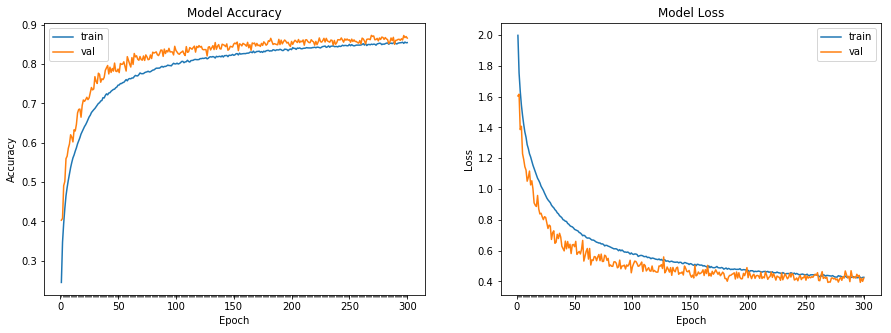

In [32]:

# Training Log 

print(model_details.history.keys())
# Create sub-plots
fig, axs = plt.subplots(1,2,figsize=(15,5))
    
# Summarize history for accuracy
axs[0].plot(range(1,len(model_details.history['accuracy'])+1),model_details.history['accuracy'])
axs[0].plot(range(1,len(model_details.history['val_accuracy'])+1),model_details.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(model_details.history['accuracy'])+1),len(model_details.history['accuracy'])/10)
axs[0].legend(['train', 'val'], loc='best')
    
# Summarize history for loss
axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
axs[1].legend(['train', 'val'], loc='best')
    
# Show the plot
plt.show()


In [36]:
# Saving Model

model.save('cifar10_finalWeight.h5')

In [34]:
# Number of correct prediction in Testing Set

class_pred = model.predict(images_test, batch_size=32)

# Convert vector to a label
labels_pred = np.argmax(class_pred,axis=1)

# Boolean array that tell if predicted label is the true label
correct = (labels_pred == labels_test)

print("Number of correct outputs from test data (10,000): ",sum(correct))

Number of correct outputs from test data (10,000):  8658
